In [8]:
import torch.nn as nn
import torch

In [9]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.metrics import mean_absolute_percentage_error
from matplotlib.pyplot import style
import mmcv
style.use('seaborn-whitegrid')

device = "cuda" if torch.cuda.is_available() else "cpu"


class RBF_Add(nn.Module):
    def __init__(self, add_rbf_number, device):
        super(RBF_Add, self).__init__()

        self.add_rbf_number = add_rbf_number
        self.radial_layer_centers_list = []
        self.radial_sigma_list = []
        self.linear_layer_weights_list = []
        
        
        self.total_radial_layer_centers_list = []
        self.total_radial_sigma_list = []
        self.total_linear_layer_weights_list = []
        
        self.change_th = 3

    def rbf_gaussian(self, input_data):
        output = torch.exp(-1 * (torch.pow((input_data - self.radial_layer_centers), 2) / \
                                 (torch.pow(self.radial_sigma, 2))))

        return output  # size = (num_rbf, 1)

    def done_rbf_gaussian(self, input_data, number):
        output = torch.exp(-1 * (torch.pow(
            (input_data - self.done_radial_layer_centers[number - 1 - self.add_rbf_number:number - 1]), 2) / \
                                 (torch.pow(self.done_radial_sigma[number - 1 - self.add_rbf_number:number - 1], 2))))

        return output  # size = (num_rbf, 1)

    def rbf_gaussian_derivative_centers(self, input_data):
        output = (2 * (input_data - self.radial_layer_centers) / \
                  (torch.pow(self.radial_sigma, 2))) * self.rbf_gaussian(input_data)

        return output  # size = (num_radial, 1)
    
    def rbf_gaussian_derivative_centers2(self, input_data):
        output = (2 / (torch.pow(self.radial_sigma, 2))) * self.rbf_gaussian(input_data) + \
                ((-2* (input_data - self.radial_layer_centers) / torch.pow(self.radial_sigma,2)) * \
                 self.rbf_gaussian_derivative_centers(input_data))

        return output  # size = (num_radial, 1)

    def rbf_gaussian_derivative_sigma(self, input_data):
        output = (2 * torch.pow((input_data - self.radial_layer_centers), 2) / \
                  (torch.pow(self.radial_sigma, 3))) * self.rbf_gaussian(input_data)

        return output  # size = (num_radial, 1)
    
    def rbf_gaussian_derivative_sigma2(self, input_data):
        output = (4 * (input_data - self.radial_layer_centers) / (torch.pow(self.radial_sigma, 3))) * \
                    self.rbf_gaussian(input_data) + (-2*(input_data - self.radial_layer_centers) / torch.pow(self.radial_sigma, 2)) * \
                    self.rbf_gaussian_derivative_sigma(input_data)

        return output  # size = (num_radial, 1)
    
    def rbf_gradient(self, input_data, centers, sigmas, weights):
        rbf_output = (-2 * (input_data-centers) / torch.pow(sigmas,2)) * \
                        (torch.exp(-1 * (torch.pow((input_data - centers), 2) / (torch.pow(sigmas, 2)))))
        rbf_grad = torch.mm(weights, rbf_output)
        
        return rbf_grad
    
    def first_grad(self, input_data, target):
        space = (input_data,)
        f_grad = torch.gradient(target[0], spacing = space, edge_order  = 1)
        return f_grad[0]
    
    def target_grad(self, input_data, centers, sigmas, weights, f_grad):
        true_grad = f_grad - self.rbf_gradient(input_data, centers, sigmas, weights)
        
        return true_grad
    
    def Loss(self, pred, target, pred_grad, true_grad):
        
        return torch.mean(torch.pow(target - pred,2) + torch.pow(true_grad - pred_grad, 2))

    def forward(self, input_data):
        rbf_output = self.rbf_gaussian(input_data)
        pred = torch.mm(self.linear_layer_weights, rbf_output)

        return rbf_output, pred

    def pred(self, input_data):
        rbf_output = torch.exp(-1 * (torch.pow((input_data - self.done_radial_layer_centers), 2) / \
                                     (torch.pow(self.done_radial_sigma, 2))))
        pred = torch.mm(self.done_linear_layer_weights, rbf_output)

        return rbf_output, pred
    
    def L2_F(self, input_data):
        return -2 * (input_data - self.radial_layer_centers) / torch.pow(self.radial_sigma, 2)
    

    def first_rbf_parameter(self, input_data, target):
        
        time_interval = int((torch.max(input_data.diff(1)) / torch.min(input_data.diff(1)).item()))
        find_index_input = input_data.clone().detach()
        fine_index_target = target.clone().detach()
        find_sigma = target.clone().detach()
        
        target_std = target.std()
        
        find_weight = target.clone().detach()
        center_index_list = []

        for i in range(self.add_rbf_number):
            index_ = torch.argmax(torch.abs(fine_index_target)).cpu().detach().tolist()
            fine_index_target[index_] = 0
            center_index_list.append(index_)

        center_index_list = torch.tensor(center_index_list, device=device)
        initcenter = torch.index_select(find_index_input, 0, center_index_list)
        initweight = torch.index_select(find_weight, 0, center_index_list)
                            

        sigma_list = []
        dft = torch.log(torch.abs(torch.fft.fft(find_sigma).real))
        dft =  torch.abs(dft / torch.max(dft)) **-1
        for k in center_index_list:
            sigma_list.append(dft[k].reshape(1))
    
        initsigma = torch.cat(sigma_list)

        return initcenter[-self.add_rbf_number:], initweight[-self.add_rbf_number:], initsigma[-self.add_rbf_number:]

    def init_rbf_parameter(self, input_data, error):
        time_interval = int((torch.max(input_data.diff(1)) / torch.min(input_data.diff(1)).item()))
        find_index_input = input_data.clone().detach()
        find_index_error = error.clone().detach()
        
        find_weight = error.clone().detach()
        find_sigma = error.clone().detach()
        
        target_std = error.std()
        center_index_list = []

        for i in range(self.add_rbf_number * (self.change_time + 1)):
            index_ = torch.argmax(torch.abs(find_index_error)).cpu().detach().tolist()

            find_index_error[index_] = 0
            center_index_list.append(index_)

        center_index_list = torch.tensor(center_index_list, device=device)
        initcenter = torch.index_select(find_index_input, 0, center_index_list)
        initweight = torch.index_select(find_weight, 0, center_index_list)

        sigma_list = []
        dft = torch.log(torch.abs(torch.fft.fft(find_sigma).real))
        
        dft =  (torch.abs(dft / torch.max(dft))**-1)
        for k in center_index_list:
            sigma_list.append(dft[k].reshape(1))

        initsigma = torch.cat(sigma_list)

        return initcenter[-self.add_rbf_number:], initweight[-self.add_rbf_number:], initsigma[-self.add_rbf_number:]

    def change_init(self, na):
        if na == 1:
            loss_list = self.train_loss_list[-self.change_th:]
            if self.number > self.change_th and max(loss_list) == min(loss_list):
                self.change_time += 1
            elif self.number > self.change_th and loss_list[0] < loss_list[1] and loss_list[1] < loss_list[2]:
                self.change_time += 1
            else:
                self.change_time = 0
        else:
            self.change_time += 1

    def best_forward(self, input_data, best_center, best_sigma, best_weight):
        rbf_output = torch.exp(-1 * (torch.pow((input_data - best_center), 2) / \
                                     (torch.pow(best_sigma, 2))))
        pred = torch.mm(best_weight, rbf_output)

        return rbf_output, pred    
    
    def L2_2_derivateive_weight(self, input_data, radial_output):
        return (-2 *(input_data - self.radial_layer_centers) / torch.pow(self.radial_sigma,2)) * radial_output

    def backward_propagation(self, input_data, radial_output, pred, target, target_grad, pred_grad):
        
        L2_1_error = -2 * (target - pred)
        L2_2_error = -2 * (target_grad - pred_grad)
        
        len_ = len(L2_2_error)

        # sigma update
        deltaSigma1 = self.rbf_gaussian_derivative_sigma(input_data) * L2_1_error
        deltaSigma1 *= self.linear_layer_weights.reshape(self.add_rbf_number, 1)
        
        deltaSigma2 = self.rbf_gaussian_derivative_sigma(input_data) * L2_2_error
        deltaSigma2 *= self.L2_F(input_data) * self.linear_layer_weights.reshape(self.add_rbf_number, 1)
        deltaSigma =  torch.sum(deltaSigma1, dim=1) + torch.sum(deltaSigma2, dim=1)

        # center update
        deltaCenter1 = self.rbf_gaussian_derivative_centers(input_data) * L2_1_error
        deltaCenter1 *= self.linear_layer_weights.reshape(self.add_rbf_number, 1)
        
        deltaCenter2 = self.rbf_gaussian_derivative_centers(input_data) * L2_2_error
        deltaCenter2 *= self.L2_F(input_data) * self.linear_layer_weights.reshape(self.add_rbf_number, 1)
        deltaCenter =  torch.sum(deltaCenter1, dim=1) + torch.sum(deltaCenter2, dim=1)

        # weight update
        delta_weight1 = torch.sum((radial_output * L2_1_error), dim=1)
        delta_weight1 = delta_weight1.reshape(1, self.add_rbf_number)
        
        delta_weight2 = torch.sum((self.L2_2_derivateive_weight(input_data, radial_output) * L2_2_error), dim = 1)
        delta_weight2 = delta_weight2.reshape(1, self.add_rbf_number)
        delta_weight = delta_weight1 + delta_weight2
        
        # BP update
        self.linear_layer_weights -= self.lr * delta_weight
        self.radial_layer_centers -= self.lr * deltaCenter.reshape(self.add_rbf_number, 1)
        self.radial_sigma -= self.lr * deltaSigma.reshape(self.add_rbf_number, 1)
        
    def train(self, input_data, target, epochs, lr, loss_th, lr_change_th):
        self.lr = lr

        self.target = target.clone().detach()
        self.number = 0
        self.train_loss_list = []
        self.loss_th = loss_th
        self.change_time = 0
        self.round_number = 5
        self.target_mape_th = torch.mean(torch.abs(target)) * 0.05
        self.lr_change_th = lr_change_th
        count_loss_chage = 0
        count_round_change = 0

        break_time = len(input_data) / self.add_rbf_number
        loss = 100000

        while self.loss_th < loss:
            print(self.number)
            # first rbf
            if self.number == 0:
                cent, weig, sig = self.first_rbf_parameter(input_data, self.target[0])
                self.radial_layer_centers = cent.reshape(self.add_rbf_number, 1)
                self.radial_sigma = sig.reshape(self.add_rbf_number, 1)
                self.linear_layer_weights = weig.reshape(1, self.add_rbf_number)
                first_grad = self.first_grad(input_data, target)
                for epo in range(epochs):
                    radial_output, pred = self.forward(input_data)
                    rbf_grad = self.rbf_gradient(input_data, self.radial_layer_centers, self.radial_sigma, self.linear_layer_weights)
                    self.backward_propagation(input_data, radial_output, pred, self.target, first_grad, rbf_grad)
                    epo_loss = self.Loss(pred, self.target, rbf_grad, first_grad)
                    if epo == 0:
                        print("{} epoch MSE Loss: {}".format(epo, epo_loss))
                        self.best_loss = epo_loss.clone().detach()
                        self.best_center = self.radial_layer_centers.clone().detach()
                        self.best_sigma = self.radial_sigma.clone().detach()
                        self.best_weight = self.linear_layer_weights.clone().detach()
                    else:
                        if self.best_loss > epo_loss:
                            self.best_loss = epo_loss.clone().detach()
                            self.best_center = self.radial_layer_centers.clone().detach()
                            self.best_sigma = self.radial_sigma.clone().detach()
                            self.best_weight = self.linear_layer_weights.clone().detach()
                    if (epo + 1) % 250 == 0:
                        print("{} epoch MSE Loss: {}".format(epo, epo_loss))

            # additional rbf
            else:
                # init parameter
                self.change_init(na)
                if self.change_time > break_time:
                    break
                cent, weig, sig = self.init_rbf_parameter(input_data, self.target[0])
                self.radial_layer_centers = cent.reshape(self.add_rbf_number, 1)
                self.radial_sigma = sig.reshape(self.add_rbf_number, 1)
                self.linear_layer_weights = weig.reshape(1, self.add_rbf_number)

                for epo in range(epochs):
                    radial_output, pred = self.forward(input_data)
                    rbf_grad = self.rbf_gradient(input_data, self.radial_layer_centers, self.radial_sigma, self.linear_layer_weights)
                    
                    if epo == 0:
                        print(self.Loss(pred, self.target, rbf_grad, target_grad))
                        self.best_loss = self.Loss(pred, self.target, rbf_grad, target_grad).clone().detach()
                        self.best_center = self.radial_layer_centers.clone().detach()
                        self.best_sigma = self.radial_sigma.clone().detach()
                        self.best_weight = self.linear_layer_weights.clone().detach()
                    
                    self.backward_propagation(input_data, radial_output, pred, self.target, target_grad, rbf_grad)
                    epo_loss = self.Loss(pred, self.target, rbf_grad, target_grad)

                    if (epo + 1) % 1000 == 0:
                        print("{} epoch MSE Loss: {}".format(epo, epo_loss))

                    # best parameter
                    if self.best_loss > epo_loss:
                        self.best_loss = epo_loss.clone().detach()
                        self.best_center = self.radial_layer_centers.clone().detach()
                        self.best_sigma = self.radial_sigma.clone().detach()
                        self.best_weight = self.linear_layer_weights.clone().detach()
                    
            radial_output, best_pred = self.best_forward(input_data, self.best_center, self.best_sigma,
                                                         self.best_weight)
            best_grad = self.rbf_gradient(input_data, self.best_center, self.best_sigma, self.best_weight)
            if self.number ==0:
                train_loss = self.Loss(best_pred, self.target, best_grad, first_grad)
            else:
                train_loss = self.Loss(best_pred, self.target, best_grad, target_grad)

            print('train_loss', train_loss)
            print("best loss : ", self.best_loss)

            if self.best_loss < self.lr_change_th:
                count_loss_chage += 1
                self.lr *= 10
                self.lr_change_th *= 0.03
                print("change lr ", self.lr)
                print('----------------------------------------------')

            if count_round_change == 0 and train_loss < self.target_mape_th:
                count_round_change += 1
                self.round_number += 1
                print("change round number", self.round_number)
                print('----------------------------------------------')

            self.train_loss_list.append(torch.round(train_loss * (10 ** self.round_number)) / 10 ** self.round_number)

            # additional rbf plot print
            plt.figure(figsize=(20, 10))
            plt.plot(input_data.cpu().detach().numpy(), self.target[0].cpu().detach().numpy())
            plt.plot(input_data.cpu().detach().numpy(), best_pred[0].cpu().detach().numpy())
            plt.show()

            if torch.isnan(train_loss) == False:
                na = 1
                self.target = self.target - best_pred  # target update
                loss = train_loss  # loss update
                self.number += 1  # additional rbf number update
                self.radial_layer_centers_list.append(self.best_center)
                self.radial_sigma_list.append(self.best_sigma)
                self.linear_layer_weights_list.append(self.best_weight)

                self.done_radial_layer_centers = torch.cat(self.radial_layer_centers_list, 0)
                self.done_radial_sigma = torch.cat(self.radial_sigma_list, 0)
                self.done_linear_layer_weights = torch.cat(self.linear_layer_weights_list, 1)
                target_grad = self.target_grad(input_data, self.done_radial_layer_centers, self.done_radial_sigma, self.done_linear_layer_weights, first_grad)
            else:
                na = 0

C:\Users\chanyoung\anaconda3\envs\cooling\lib\site-packages\mmcv\__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [224]:
a = np.arange(0,10,0.05)
    
y = 5*a*np.sin(np.pi*a/4)

target3 = torch.tensor(y, device = device).reshape((1,200))
input_2 = torch.tensor(a, device = device)

In [227]:
input_2.dtype

torch.float64

In [226]:
target3.dtype

torch.float64

0
0 epoch MSE Loss: 477219.45517577184
249 epoch MSE Loss: 19.651472029949154
499 epoch MSE Loss: 13.845007636081114
749 epoch MSE Loss: 7.491895462864786
999 epoch MSE Loss: 4.56646282058342
1249 epoch MSE Loss: 3.450825257977573
1499 epoch MSE Loss: 2.675356694454491
1749 epoch MSE Loss: 1.7598026175717072
1999 epoch MSE Loss: 0.7152413129246239
2249 epoch MSE Loss: 0.16769451815309439
2499 epoch MSE Loss: 0.0942080649066775
2749 epoch MSE Loss: 0.08392939197257192
2999 epoch MSE Loss: 0.07644413684751854
3249 epoch MSE Loss: 0.07125375602945584
3499 epoch MSE Loss: 0.0679466428210129
3749 epoch MSE Loss: 0.06585319173559029
3999 epoch MSE Loss: 0.06449337811333956
4249 epoch MSE Loss: 0.06357044503471719
4499 epoch MSE Loss: 0.06290589387288748
4749 epoch MSE Loss: 0.06239173706004381
4999 epoch MSE Loss: 0.06196166619363218
train_loss tensor(0.0620, device='cuda:0', dtype=torch.float64)
best loss :  tensor(0.0620, device='cuda:0', dtype=torch.float64)
change lr  0.0001
------------

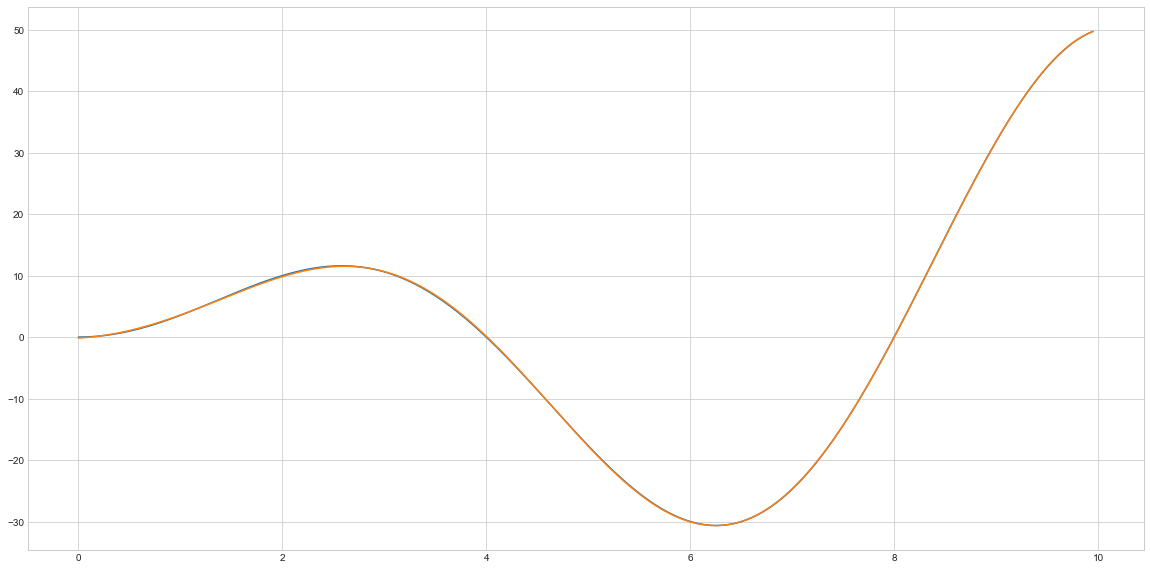

1
tensor(4.7431, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 0.01758911284309693
1999 epoch MSE Loss: 0.015308565765742861
2999 epoch MSE Loss: 0.013703341341767579
3999 epoch MSE Loss: 0.01211298634906817
4999 epoch MSE Loss: 0.010757656567204113
train_loss tensor(0.0108, device='cuda:0', dtype=torch.float64)
best loss :  tensor(0.0108, device='cuda:0', dtype=torch.float64)
change lr  0.001
----------------------------------------------


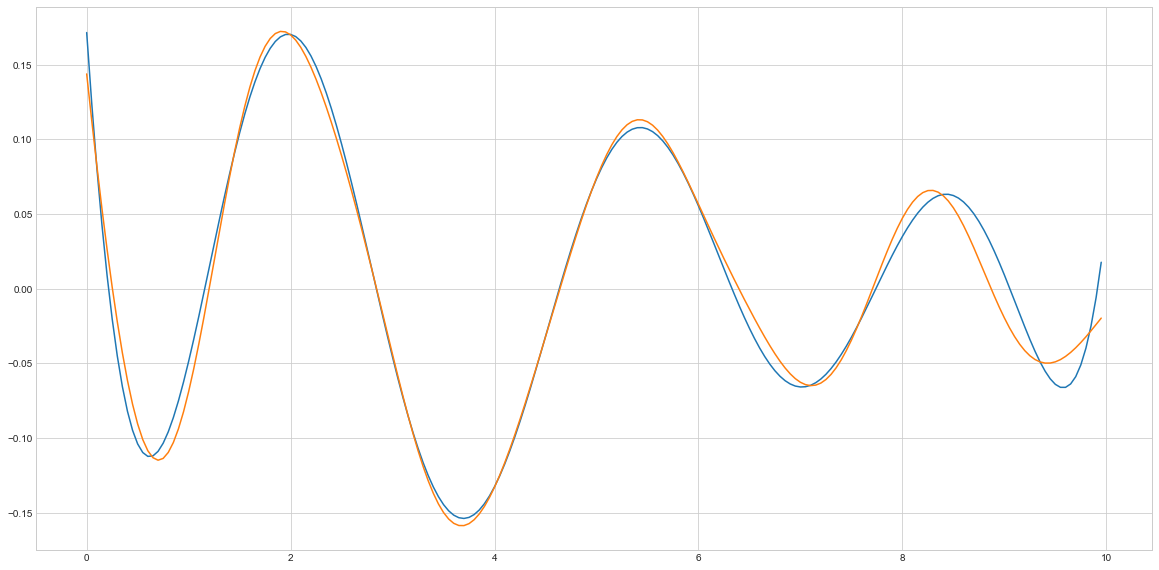

2
tensor(0.0320, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 0.006571040711655133
1999 epoch MSE Loss: 0.005879020437207513
2999 epoch MSE Loss: 0.005320808723361057
3999 epoch MSE Loss: 0.008856452609943567
4999 epoch MSE Loss: 0.008215814377834483
train_loss tensor(0.0021, device='cuda:0', dtype=torch.float64)
best loss :  tensor(0.0021, device='cuda:0', dtype=torch.float64)
change lr  0.01
----------------------------------------------


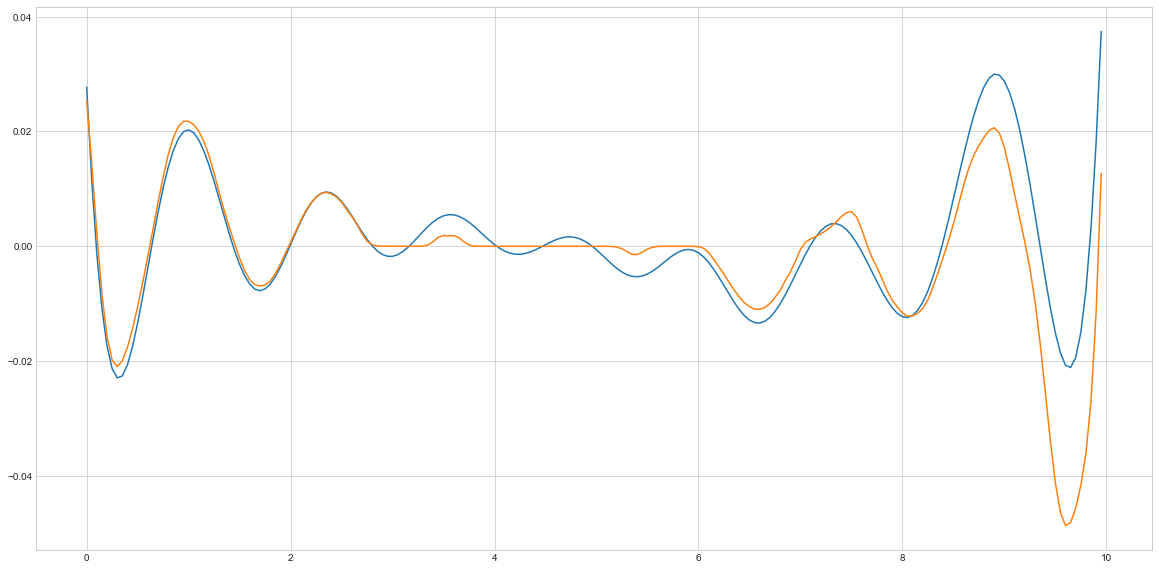

30.85917 sec


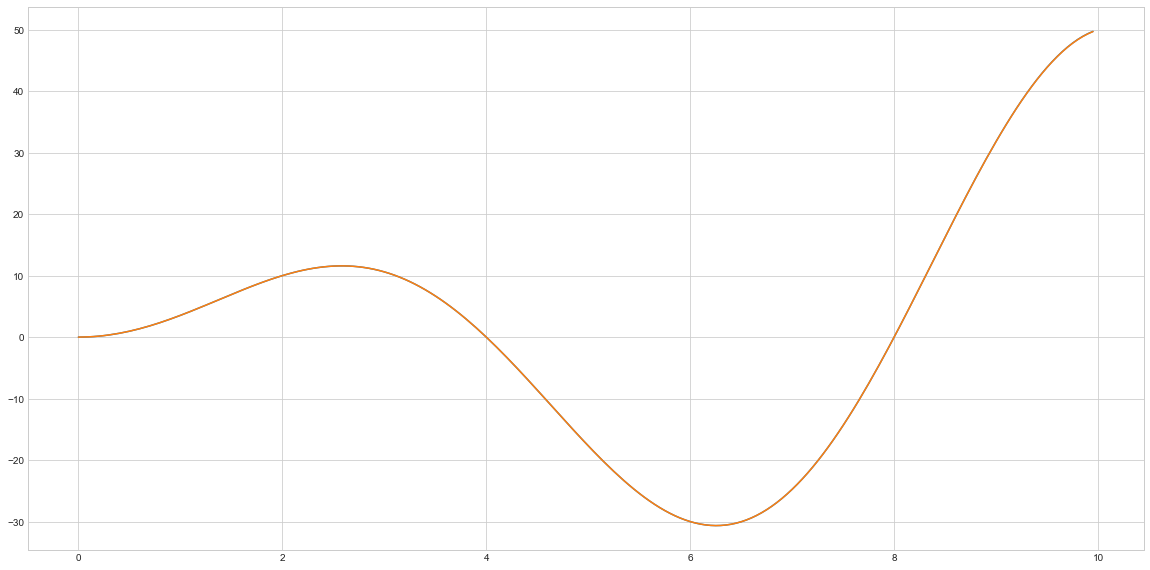

In [12]:
start = time.time()
model2 = RBF_Add(100, device)
model2.train(input_2, target3, 5000, 1e-05, 0.01, 10)
end = time.time()
print(f"{end - start:.5f} sec")

plt.figure(figsize=(20,10))
plt.plot(input_2.cpu().detach().numpy(), target3[0].cpu().detach().numpy())
plt.plot(input_2.cpu().detach().numpy(), model2.pred(input_2)[1][0].cpu().detach().numpy())
#rbf_grad2 = rbf_gradient(input_2, model2.done_radial_layer_centers, model2.done_radial_sigma, model2.done_linear_layer_weights)

In [14]:
weight = model2.done_linear_layer_weights
center = model2.done_radial_layer_centers
sigma = model2.done_radial_sigma

In [33]:
a = torch.cat([center.reshape(1,300), sigma.reshape(1,300), weight], dim = 0)

In [44]:
sort, index = torch.sort(center.reshape(1,300), stable = True)

In [46]:
index

tensor([[206, 100, 132, 250, 174, 255,   3, 228, 213, 210, 212, 188, 172, 216,
         227, 161, 238, 151, 139, 267, 137, 138, 141, 288, 152, 258, 160, 168,
         236, 178, 199,  99, 229, 223, 219, 218, 220, 225, 230, 235, 177, 251,
         271, 164, 150, 135, 284, 129, 279, 125, 276, 119, 280, 110, 108, 285,
         106, 298, 104, 102,  56, 101,  61, 103,  51, 105, 107,  66, 287, 109,
         278, 117, 268,  39, 122,  36, 265, 128,  45, 262, 133, 264,  41, 140,
         266,  70, 158,  34, 274, 171, 283, 182, 295,  38,  43,  33,  89, 180,
          96, 169,  46,  27, 159, 145,  75, 136, 131, 126, 123, 296, 120,  31,
         116, 290,  98,  79, 291, 114,  83,  88, 112, 111,  48, 113,  19, 115,
         118,  94, 121, 124, 127, 130,  86, 134, 142, 155,  50, 166, 175,  29,
         183,  18,  92,  53,  85, 190, 179,  76,  73,  55, 173,  77,  82,  71,
         167,  80,  17,  91, 163,  68, 157,  67, 154,  57, 149,  64,  59, 147,
         299,  62,  26, 144, 297, 143, 146, 148,  93

In [51]:
c = torch.zeros_like(weight, device = device)
for i in range(weight.size(1)):
    c[0][i] = weight[0][index[0][i]]

In [52]:
c

tensor([[ 4.3526e-02,  4.2095e-01,  3.1236e-01,  1.8355e-02,  1.8983e-01,
         -4.6331e-02,  4.7004e+01, -4.1478e-03,  2.6925e-02, -5.3544e-04,
          1.6099e-03,  1.3422e-01, -4.9425e-03,  1.0847e-02, -1.6389e-02,
          1.3771e-01, -2.1876e-02, -2.0000e-02,  1.8577e-02,  1.4565e-03,
          6.4125e-02,  2.8470e-02, -3.6652e-02,  1.5075e-02, -1.1220e-01,
         -1.5202e-03, -1.8929e-01, -2.6188e-01, -5.9557e-03, -3.2576e-01,
         -3.7823e-01, -1.0056e+01,  2.4013e-03,  9.3723e-03,  7.1582e-03,
          5.9298e-04, -3.3584e-03, -1.4079e-03,  3.3293e-03,  6.3179e-03,
         -2.4937e-01,  4.2762e-03, -7.5341e-03, -1.6114e-01, -6.4284e-02,
          2.1847e-02, -8.5938e-03,  7.9338e-02,  2.5690e-03,  1.0843e-01,
         -2.6202e-03,  1.1783e-01, -3.6911e-03,  1.1444e-01,  1.0241e-01,
          1.1239e-03,  8.4193e-02, -4.5366e-03,  6.1456e-02,  3.5676e-02,
          2.2536e+01,  8.6210e-03,  2.1031e+01, -1.7415e-02,  2.4047e+01,
         -3.9862e-02, -5.6578e-02,  1.

In [53]:
def Continuous_tensor(centers, weights, sigmas):
    C, index = torch.sort(centers.T, stable = True)
    S = torch.zeros_like(weights, device = device)
    W = torch.zeros_like(weights, device = device)
    for i in range(index.size(1)):
        S[0][i] = sigmas[index[0][i]]
        W[0][i] = weights[0][index[0][i]]
    
    return torch.cat([C, S, W], dim = 0)

In [57]:
A = Continuous_tensor(center, weight, sigma)

In [156]:
def CausalConv1d(in_channels, out_channels, kernel_size, dilation=1, **kwargs):
    pad = (kernel_size -1 )* dilation
    return nn.Conv1d(in_channels = in_channels, out_channels= out_channels, kernel_size= kernel_size, padding=pad, dilation=dilation, device = device)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import time
import argparse
import pickle
import os
import datetime
from torch.autograd import Variable
import torch.optim as optim
from torch.optim import lr_scheduler
import networkx as nx

In [219]:
device = "cuda" if torch.cuda.is_available() else "cpu"

T0 = torch.load('T0.pt')
T1 = torch.load('T1.pt')
T2 = torch.load('T2.pt')
T3 = torch.load('T3.pt')
T4 = torch.load('T4.pt')

In [192]:
def Continuous_tensor(centers, weights, sigmas):
    C, index = torch.sort(centers.T, stable = True)
    S = torch.zeros_like(weights, device = device)
    W = torch.zeros_like(weights, device = device)
    for i in range(index.size(1)):
        S[0][i] = sigmas[index[0][i]]
        W[0][i] = weights[0][index[0][i]]
    
    return torch.cat([C, S, W], dim = 0)

class RBFnnCausal(nn.Module):
    def __init__(self,rbfnum):
        super(RBFnnCausal, self).__init__()
        self.rbfnum = rbfnum
        self.causalconvlist = nn.ModuleList([self.CausalConv1d(kernel_size = i) for i in rbfnum])
    
    def CausalConv1d(self, kernel_size, in_channels=3 , out_channels= 1, dilation=1, **kwargs):
        return nn.Conv1d(in_channels = in_channels, out_channels= out_channels, stride=kernel_size, kernel_size= kernel_size, padding=0, dilation=dilation, device = device)
    
    def forward(self, X):
        for i in range(len(X)):
            X[i] = self.causalconvlist[i](X[i].float())
            
        return X

In [220]:
X = []
X.append(T0)
X.append(T1)
X.append(T2)
X.append(T3)
X.append(T4)

rbfnumlist = []

for x in X:
    rbfnumlist.append(int(x.size(1) / 50))

In [221]:
rbfnumlist

[12, 5, 5, 110, 37]

In [222]:
print(T0.size())
print(T1.size())
print(T2.size())
print(T3.size())
print(T4.size())

torch.Size([3, 600])
torch.Size([3, 250])
torch.Size([3, 250])
torch.Size([3, 5500])
torch.Size([3, 1850])


In [196]:
model = RBFnnCausal(rbfnumlist)

In [197]:
out = model(X)

In [218]:
a = torch.zeros((50,5,1), device = device)

In [213]:
a[:,0,:].size()

torch.Size([50, 1])

In [214]:
for i in range(5):
    a[:,i,:] = out[i].T

In [217]:
a

tensor([[[  -3.1176],
         [   0.8784],
         [   3.3325],
         [  59.7690],
         [  -4.5123]],

        [[  -2.7136],
         [  12.4063],
         [   6.9518],
         [  13.4422],
         [  -2.2673]],

        [[ -18.5570],
         [  14.7680],
         [   8.6087],
         [  22.2807],
         [   3.4730]],

        [[ -11.8905],
         [  17.1117],
         [  14.0588],
         [ 663.2176],
         [   5.5285]],

        [[  -6.9265],
         [  20.1754],
         [  15.7913],
         [  43.9606],
         [   1.6012]],

        [[ -10.8467],
         [  28.1971],
         [  24.1648],
         [  44.5315],
         [  11.9467]],

        [[ -11.6613],
         [ -29.0994],
         [  28.7976],
         [  55.1401],
         [  12.8558]],

        [[ -12.8413],
         [  42.7485],
         [  32.8992],
         [  50.8291],
         [  16.0120]],

        [[ -20.4671],
         [  35.4010],
         [  39.0004],
         [  70.4784],
         [  14.0

In [198]:
for x in out:
    print(x.size())

torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])


In [199]:
import math

In [204]:
math.gcd(1850, 250, 600)

50